In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import sklearn.model_selection as ms
from sklearn.naive_bayes import *
from sklearn.multiclass import *
from sklearn.svm import *
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import re
import os
%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [26]:

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

from sklearn.metrics import *
from sklearn.calibration import *
def performance_metrics(y_true,y_score,y_pred,pos):
    #f1 score
    f1 = f1_score(y_true,y_pred,average="macro",pos_label=pos)
    print('F1 score: {0:0.2f}'.format(f1))
    
    #precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_true,y_score,pos_label=pos)
    
    
    print('Average precision: {0:0.2f}'.format(np.mean(precision)))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
              np.mean(precision)))
    


    #ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true,y_score,pos_label=pos)
    auc = np.trapz(tpr,fpr)
    print('ROC curve AUC= {0:0.2f}'.format(auc))
    plt.figure()
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve AUC= {0:0.2f}'.format(
              auc))

    
    #accuracy
    accuracy = accuracy_score(y_true,y_pred)
    print('Accuracy: {0:0.2f}'.format(accuracy))
    
    #brier score
    brier = brier_score_loss(y_true,y_score)
    print('Brier score: {0:0.2f}'.format(brier))

In [4]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords)
        return clean_X

In [7]:
all_df = pd.read_csv('data/10k_sentiment.csv')

In [8]:
all_df

,text,score
0,@VirginAmerica happy to spend the day together...,1
1,"I also didn't like the ""on"" button, it felt li...",0
2,"Redundant, everlasting shots, useless shots, u...",0
3,thunderstruck: much of this book was tedious. ...,0
4,@SouthwestAir JUST GAVE ME TICKETS TO SEE @Ima...,1
...,...,...
9995,@united have an employee at the gate 15min bef...,0
9996,@united was forced to book a flight on a diff...,0
9997,The first murder scene is one of the best murd...,1
9998,This is a classic stinker with a big named cas...,0


In [10]:
ct = CleanText()
sr_clean = ct.fit_transform(all_df.text)
sr_clean.sample(5)

5724    pretty afar actually work bought globe husband...
619     okay book really cool wanted star wonders best...
2968    high expectations movie excited renting disapp...
9666    create reality core question behind highly ori...
4617    positive thing think regarding utter piece gar...
Name: text, dtype: object

In [21]:
all_df.text = sr_clean

In [22]:
all_df.text[45]

'seen cheesy kung fu fight films living taiwan come lieu sitcoms america seen movies make fun film belongs sad category fight films try hard awful actors awful props awful music taken seriously seriously felt pity person composed music movie sad must composer churn crap like thought titled generic ninja fight scene op variations bad guy pointing gun girl head backed corner daring flight helicopter fight scenes credits rolled actually tears laughing special effects proof enough low budget fact two three crew members presumably locals although good much needed phillipino economy probably done solely save money ever done anything since series movies rented equipment despite making sequels movie pretty funny thing really going though not music left half expecting animated sargeant slaughter joe pop ending suppose would spoiler really plot spoil american ninja drops girl jackson arms takes mask wanted see jump roof jackson drop girl catch br br think would perfect punchline joke movie'

In [23]:
train_set,test_set = ms.train_test_split(all_df)

In [24]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

def perform(classifiers, vectorizers, train_set, test_set):
    
    
    for vectorizer in vectorizers:
        
        vectorize_text = vectorizer.fit_transform(train_set.text)
        vectorize_text = vectorize_text.toarray()
        
        vectorize_test_text = vectorizer.transform(test_set.text)
        vectorize_test_text = vectorize_test_text.toarray()
        
        for classifier in classifiers:
            string = ''
            string += classifier.__class__.__name__ + ' with ' + vectorizer.__class__.__name__
            
            # train
            y = train_set.score
            classifier.fit(vectorize_text, y)

            # score
            score = classifier.score(vectorize_test_text, test_set.score)
            string += '. Has accuracy: ' + str(score)
            print(string)
            class_names = [0,1]
            y_true = test_set.score
            y_score = classifier.predict_proba(vectorize_test_text)
            y_score = [i[0] for i in y_score]
            y_predict = classifier.predict(vectorize_test_text)
            plt.figure()
            performance_metrics(y_true,y_score,y_predict,class_names[0])
            cnf_matrix = confusion_matrix(y_true,y_predict)
            
            
            plot_confusion_matrix(classifier,vectorize_test_text,y_true,normalize='true')
            plt.show()
    return vectorizer,classifier

/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


MultinomialNB with TfidfVectorizer. Has accuracy: 0.8228


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


F1 score: 0.82
Average precision: 0.81
ROC curve AUC= 0.91
Accuracy: 0.82
Brier score: 0.44


<Figure size 432x288 with 0 Axes>

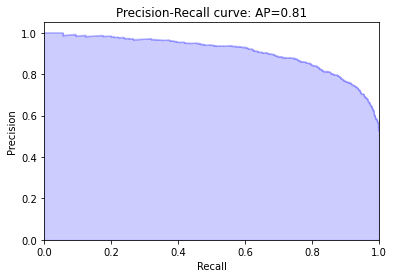

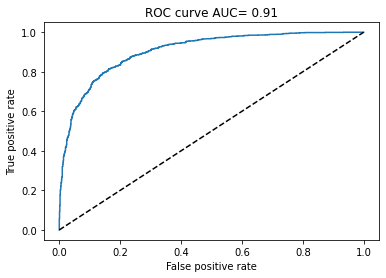

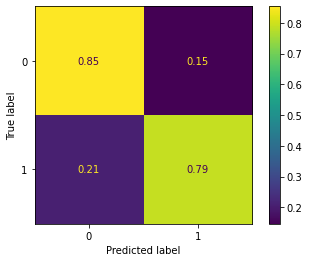

BernoulliNB with TfidfVectorizer. Has accuracy: 0.8152


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


F1 score: 0.81
Average precision: 0.79
ROC curve AUC= 0.88
Accuracy: 0.82
Brier score: 0.68


<Figure size 432x288 with 0 Axes>

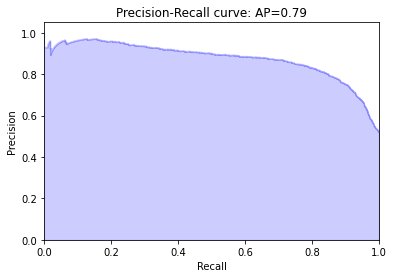

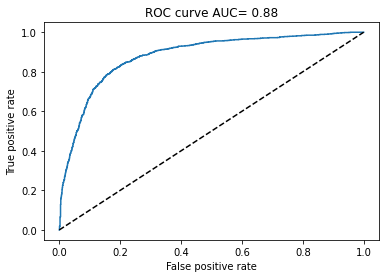

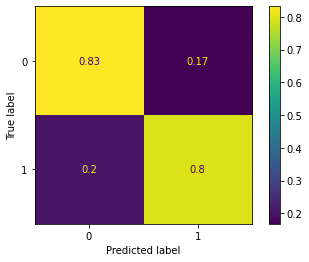

MultinomialNB with CountVectorizer. Has accuracy: 0.8164


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


F1 score: 0.82
Average precision: 0.78
ROC curve AUC= 0.88
Accuracy: 0.82
Brier score: 0.70


<Figure size 432x288 with 0 Axes>

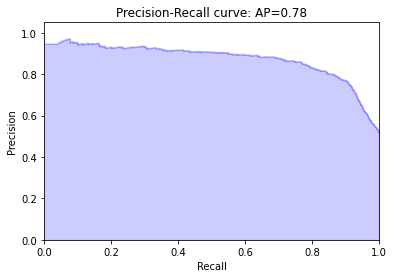

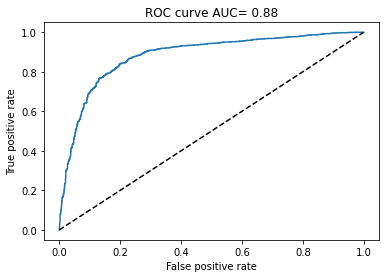

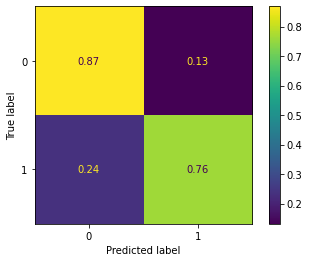

BernoulliNB with CountVectorizer. Has accuracy: 0.824


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1270: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


F1 score: 0.82
Average precision: 0.79
ROC curve AUC= 0.89
Accuracy: 0.82
Brier score: 0.71


<Figure size 432x288 with 0 Axes>

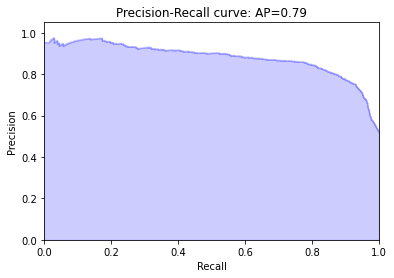

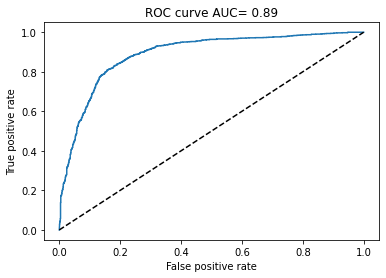

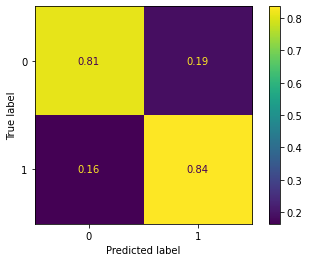

In [27]:
vectorizer,classifier = perform([MultinomialNB(),BernoulliNB()],
                                [TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True),CountVectorizer()],
       train_set,
       test_set)

In [91]:
sentence = pd.Series(["😃"])

In [92]:
sentence = ct.transform(sentence)
sentence

0    
dtype: object

In [93]:
transformed = vectorizer.transform(sentence)
transformed = transformed.toarray()
classifier.predict_proba(transformed)

array([[0.25939937, 0.74060063]])

In [89]:
print("🙁")

🙁


In [90]:
🙁 = 'test'

SyntaxError: invalid character in identifier (<ipython-input-90-b0dcd9ca2408>, line 1)